# Time series with RNN

In [1]:
import numpy as np
import pandas as pd
import math
import datetime
import yfinance as yf
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.layers import (Dense, Dropout, Activation, Flatten, MaxPooling2D, SimpleRNN)
from sklearn.model_selection import train_test_split

In [2]:
n_steps = 13
n_features = 1

In [3]:
model = Sequential()
model.add(SimpleRNN(512, activation='relu', input_shape=(n_steps, n_features), return_sequences=True))
model.add(Dropout(0.2))
model.add(Dense(256, activation='relu'))
model.add(Flatten())
model.add(Dense(1, activation='linear'))

In [38]:
model.compile(optimizer='rmsprop', loss='mean_squared_error', metrics=['mse'])

In [39]:
def split_sequence(sequence, n_steps):
    X, y = [], []
    for i in range(len(sequence)):
        end_ix = i + n_steps
        if end_ix > len(sequence) - 1:
            break
        seq_x, seq_y = sequence[i:end_ix], sequence[end_ix]
        X.append(seq_x)
        y.append(seq_y)
    return np.array(X), np.array(y)

In [40]:
ticker = ['AAPL', 'MSFT']
start = datetime.datetime(2019, 1, 1)
end = datetime.datetime(2020, 1, 1)
stock_prices = yf.download(ticker, start=start, end=end, interval='1d').Close

[*********************100%%**********************]  2 of 2 completed


In [41]:
diff_stock_prices = stock_prices.diff().dropna()

In [42]:
split = int(len(diff_stock_prices['AAPL'].values) * 0.95)
diff_train_aapl = diff_stock_prices['AAPL'].iloc[:split]
diff_test_aapl = diff_stock_prices['AAPL'].iloc[split:]
diff_train_msft = diff_stock_prices['MSFT'].iloc[:split]
diff_test_msft = diff_stock_prices['MSFT'].iloc[split:]

In [43]:
X_aapl, y_aapl = split_sequence(diff_train_aapl, n_steps)
X_aapl = X_aapl.reshape((X_aapl.shape[0], X_aapl.shape[1], n_features))

In [44]:
history = model.fit(X_aapl, y_aapl, epochs=400, batch_size=150, verbose=0, validation_split=0.10)

In [45]:
start = X_aapl[X_aapl.shape[0] - n_steps]
x_input = start
x_input = x_input.reshape((1, n_steps, n_features))

In [47]:
tempList_aapl = []
for i in range(len(diff_test_aapl)):
    x_input = x_input.reshape((1, n_steps, n_features))
    yhat = model.predict(x_input, verbose=0)
    x_input = np.append(x_input, yhat)
    x_input = x_input[1:]
    tempList_aapl.append(yhat)

In [49]:
X_msft, y_msft = split_sequence(diff_train_msft, n_steps)
X_msft = X_msft.reshape((X_msft.shape[0], X_msft.shape[1], n_features))

In [50]:
history = model.fit(X_msft, y_msft, epochs=400, batch_size=150, verbose=0, validation_split=0.10)

In [51]:
start = X_msft[X_msft.shape[0] - n_steps]
x_input = start
x_input = x_input.reshape((1, n_steps, n_features))

In [52]:
tempList_msft = []
for i in range(len(diff_test_msft)):
    x_input = x_input.reshape((1, n_steps, n_features))
    yhat = model.predict(x_input, verbose=0)
    x_input = np.append(x_input, yhat)
    x_input = x_input[1:]
    tempList_msft.append(yhat)

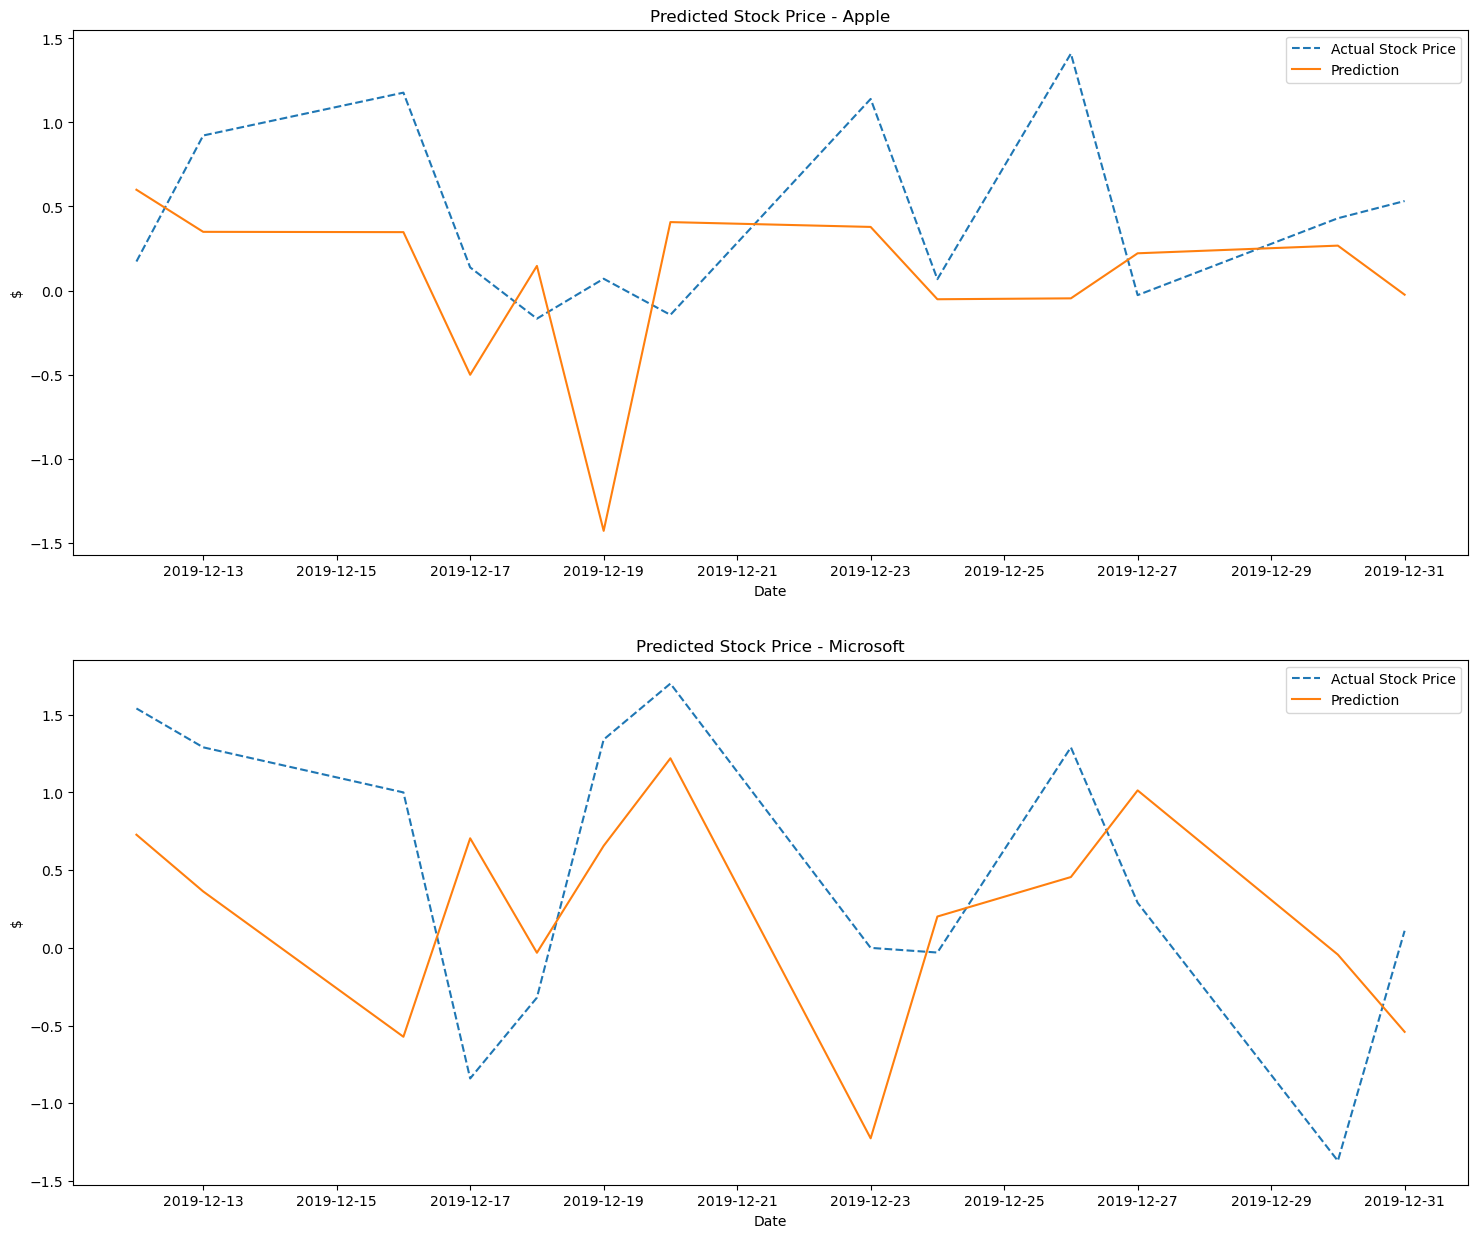

In [54]:
fig, ax = plt.subplots(2, 1, figsize=(18, 15))
ax[0].plot(diff_test_aapl, label='Actual Stock Price', linestyle='--')
ax[0].plot(diff_test_aapl.index, np.array(tempList_aapl).flatten(), linestyle='solid', label='Prediction')
ax[0].set_title('Predicted Stock Price - Apple')
ax[0].legend(loc='best')
ax[1].plot(diff_test_msft, label='Actual Stock Price', linestyle='--')
ax[1].plot(diff_test_msft.index, np.array(tempList_msft).flatten(), linestyle='solid', label='Prediction')
ax[1].set_title('Predicted Stock Price - Microsoft')
ax[1].legend(loc='best')
for ax in ax.flat:
    ax.set(xlabel='Date', ylabel='$')
plt.show()


# Time series with LSTM